<a href="https://colab.research.google.com/github/stonkpab/df-detect/blob/main/df_test_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [ ]:
#library for heatmaps
!pip install keract

In [ ]:
#imports for heatmap, preprocessing, and model execution
import cv2 
import os
import os
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
from keras.applications.xception import preprocess_input # to preprocess the input
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
import keract
import tensorflow.keras.backend as K
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import math

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = "/content/drive/My Drive/extracted2/"

Mounted at /content/drive


#Testing Pipeline

In [ ]:
#function for preprocessing video
def preprocess_video(video_name):
  #if loading video that is already downloaded
  if video_name != None:
    try:
      cam = cv2.VideoCapture("/content/" + video_name)
    except Error as e:
      print("Ensure that the video name is accurate and contains the .mp4 extension")
      print(e)
  #if loading new video from manual upload
  else:
    vid = files.upload()
    for i,k in enumerate(vid.keys()):
      if i == 0:
        video = k
    cam = cv2.VideoCapture("/content/" + video)
  img_seq = []
  #frame extraction
  for i in range(121):
    ret, frame = cam.read()
    #half second timestep that starts 2 seconds in
    if ret and i % 15 == 0 and i >= 60:
      img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
      faces = face_detector(img, 0)
      if len(faces) == 0: #checks if face wasn't detected
        faces = face_detector(img, 1) #updates complexity
      if len(faces) != 0: #checks if face wasn't detected
        if len(faces) != 1: #checks for multiple faces
          areas = []
          for face in faces:
            x = face.left()
            y = face.top()
            w = face.right() - x
            h = face.bottom() - y
            areas.append(w*h)
          #utilize face that covers most area in picture
          largest_index = areas.index(max(areas))
          faces = [faces[largest_index]]
        #crop out face and resize
        img = img[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()]
        img = cv2.resize(img,(299,299))
        img_seq.append(img)
      else:
        print("Faces weren't detected")
        img = cv2.resize(img,(299,299))
        img_seq.append(img)
  cam.release()
  cv2.destroyAllWindows()
  #returns preprocessed video as array after preprocessed according to xception
  return np.array([preprocess_input(np.array(img_seq).reshape(-1, 299, 299, 3))])

In [ ]:
#load keras model
model = keras.models.load_model("/content/drive/My Drive/extracted2/model.h5")

In [ ]:
def heatmaps(activations, input_images, directory='.', save=False, fix=True):
    """
    Plot heatmaps of activations for all filters overlayed on the input image for each layer
    :param activations: dict mapping layers to corresponding activations with the shape
    (1, output height, output width, number of filters)
    :param input_images: numpy array, input image for the overlay
    :param save: bool, if the plot should be saved
    :param fix: bool, if automated checks and fixes for incorrect images should be run
    :param directory: string - where to store the activations (if save is True)
    :return: None
    """
    for n in range(5):
        data_format = K.image_data_format()
        input_image = input_images[n]
        if fix:
            # fixes common errors made when passing the image
            # I recommend the use of keras' load_img function passed to np.array to ensure
            # images are loaded in in the correct format
            # removes the batch size from the shape
            if len(input_image.shape) == 4:
                input_image = input_image.reshape(input_image.shape[1], input_image.shape[2], input_image.shape[3])
            # removes channels from the shape of grayscale images
            if len(input_image.shape) == 3 and input_image.shape[2] == 1:
                input_image = input_image.reshape(input_image.shape[0], input_image.shape[1])
        act = activations[n]
        if act.shape[0] != 1:
            print('-> Skipped. First dimension is not 1.')
            continue
        if len(act.shape) <= 2:
            print('-> Skipped. 2D act.')
            continue
        print('')
        nrows = int(math.sqrt(act.shape[-1]) - 0.001) + 1  # best square fit for the given number
        ncols = int(math.ceil(act.shape[-1] / nrows))
        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
        fig.suptitle("Frame " + str(n+1))
        # computes values required to scale the activations (which will form our heat map) to be in range 0-1
        scaler = MinMaxScaler()
        # reshapes to be 2D with an automaticly calculated first dimension and second
        # dimension of 1 in order to keep scikitlearn happy
        scaler.fit(act.reshape(-1, 1))
        maxi = 0
        # loops over each filter/neuron
        for i in range(nrows * ncols):
            if i < act.shape[-1]:
                if len(act.shape) == 3:
                    # gets the activation of the ith layer
                    if data_format == 'channels_last':
                        img = act[0, :, i]
                    elif data_format == 'channels_first':
                        img = act[0, i, :]
                    else:
                        raise Exception('Unknown data_format.')
                elif len(act.shape) == 4:
                    if data_format == 'channels_last':
                        img = act[0, :, :, i]
                    elif data_format == 'channels_first':
                        img = act[0, i, :, :]
                    else:
                        raise Exception('Unknown data_format.')
                else:
                    raise Exception('Expect a tensor of 3 or 4 dimensions.')

                # scales the activation (which will form our heat map) to be in range 0-1 using
                # the previously calculated statistics
                if len(img.shape) == 1:
                    img = scaler.transform(img.reshape(-1, 1))
                else:
                    img = scaler.transform(img)
                # print(img.shape)
                img = Image.fromarray(img)
                # resizes the activation to be same dimensions of input_image
                img = img.resize((input_image.shape[1], input_image.shape[0]), Image.LANCZOS)
                img = np.array(img)
                if hasattr(axes, 'flat'):
                    #normalize from range (-1,1) to (0,1)
                    axes.flat[i].imshow((input_image+1)/2)
                    # overlay the activation at 70% transparency  onto the image with a heatmap colour scheme
                    # Lowest activations are dark, highest are dark red, mid are yellow
                    axes.flat[i].imshow((img+1)/2, alpha=0.3, cmap='jet', interpolation='bilinear')
                else:
                    axes.imshow((input_image+1)/2)
                    axes.imshow((img+1)/2, alpha=0.3, cmap='jet', interpolation='bilinear')
            # axis off.
            axes.flat[i].axis('off') if hasattr(axes, 'flat') else axes.axis('off')
    plt.close(fig)

In [ ]:
#use to run a prediction from any video with the model, returns preprocessed image sequence 
def predict(video_name=None):
  img_seq = preprocess_video(video_name)
  pred = model.predict(img_seq)
  print("")
  if pred[0][0] > pred[0][1]:
    print("The model predicts this video to be real with " + str(int(round(pred[0][0]* 100,0))) + "% confidence.")
  else:
    print("The model predicts this video to be fake with " + str(int(round(pred[0][1]* 100,0))) + "% confidence.")
  return img_seq

In [ ]:
#use display heatmaps over every activation of an image sequence in time distributed convolutional layer
def display_heatmaps(img_seq):
  activations = keract.get_activations(model, img_seq, layer_names="time_distributed_9", nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
  new_activations = np.squeeze(activations["time_distributed_9"],axis = 0)
  acts = np.array_split(new_activations,5)
  frames = np.array_split(np.squeeze(img_seq,axis = 0),5)
  heatmaps(acts, frames)
  return acts, frames

In [ ]:
#use to focus on a singular heatmap
def focus_heatmap(acts, frames, n, row, col):
    """
    acts: output of display_heatmaps
    frames: output of display_heatmaps
    n: frame number
    row: row of heatmap from display_heatmaps
    col: column of heatmap from display_heatmaps
    """
    data_format = K.image_data_format()
    input_image = frames[n-1]
    if len(input_image.shape) == 4:
        input_image = input_image.reshape(input_image.shape[1], input_image.shape[2], input_image.shape[3])
    # removes channels from the shape of grayscale images
    if len(input_image.shape) == 3 and input_image.shape[2] == 1:
        input_image = input_image.reshape(input_image.shape[0], input_image.shape[1])
    act = acts[n-1]
    if act.shape[0] != 1:
        print('-> Skipped. First dimension is not 1.')
    if len(act.shape) <= 2:
        print('-> Skipped. 2D act.')
    # computes values required to scale the activations (which will form our heat map) to be in range 0-1
    scaler = MinMaxScaler()
    # reshapes to be 2D with an automaticly calculated first dimension and second
    # dimension of 1 in order to keep scikitlearn happy
    scaler.fit(act.reshape(-1, 1))
    # loops over each filter/neuron
    i = (row-1)*8+col-1
    img = act[0, :, :, i]
    if len(img.shape) == 1:
        img = scaler.transform(img.reshape(-1, 1))
    else:
        img = scaler.transform(img)
    img = Image.fromarray(img)
    # resizes the activation to be same dimensions of input_image
    img = img.resize((input_image.shape[1], input_image.shape[0]), Image.LANCZOS)
    img = np.array(img)
    plt.figure(figsize=(10,10))
    plt.imshow((input_image+1)/2)
    # overlay the activation at 70% transparency  onto the image with a heatmap colour scheme
    # Lowest activations are dark, highest are dark red, mid are yellow
    plt.imshow((img+1)/2, alpha=0.3, cmap='jet', interpolation='bilinear')

#Tests

In [ ]:
img_seq = predict()

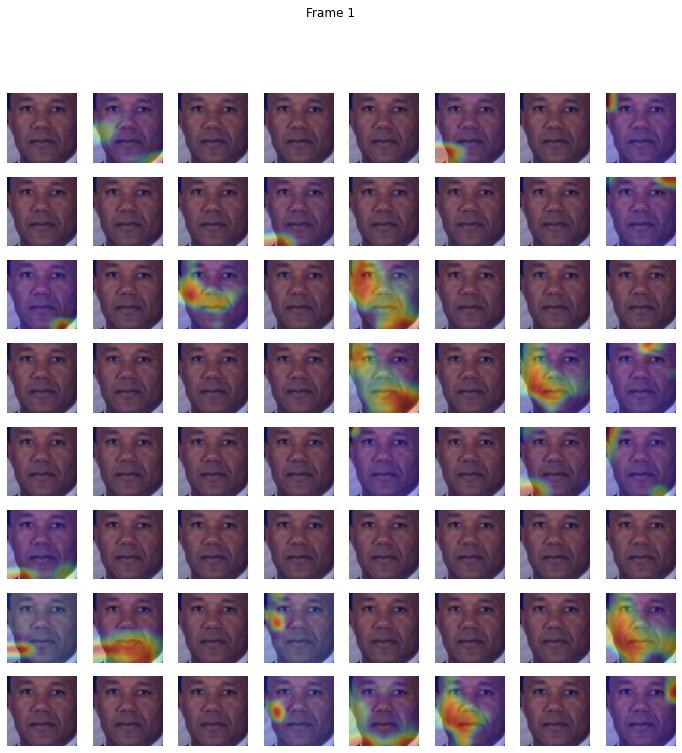

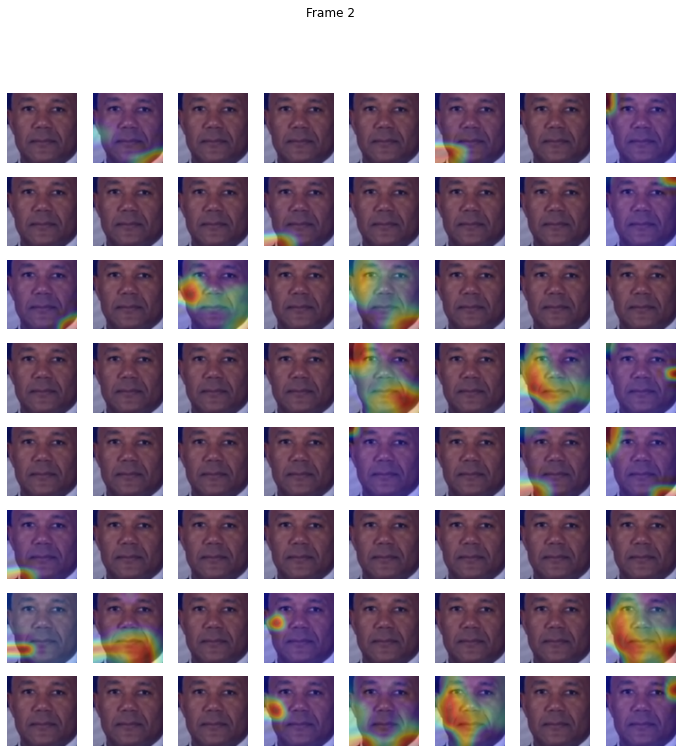

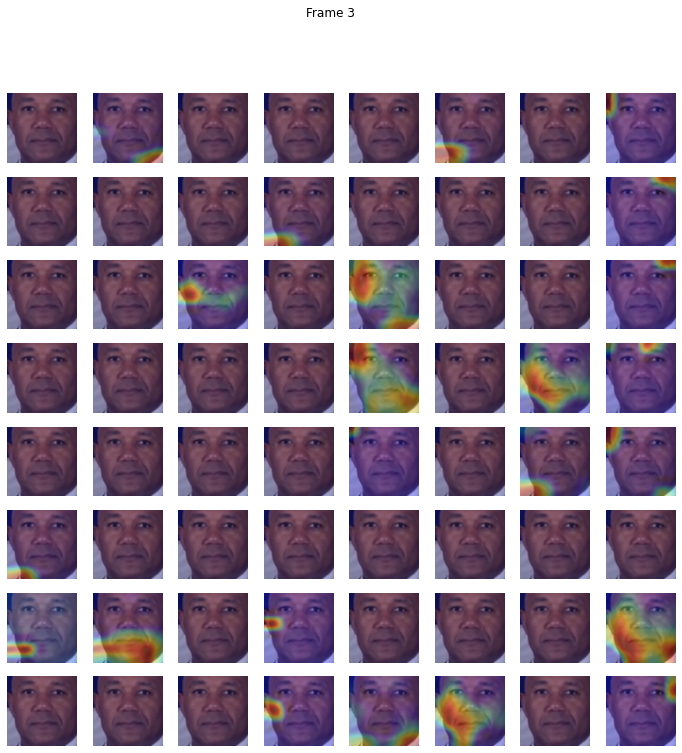

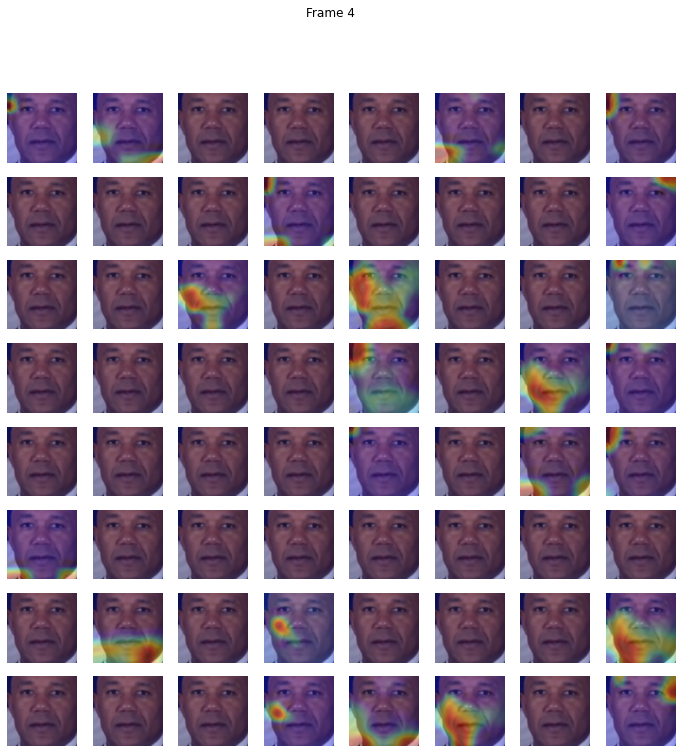

In [ ]:
acts, frames = display_heatmaps(img_seq)

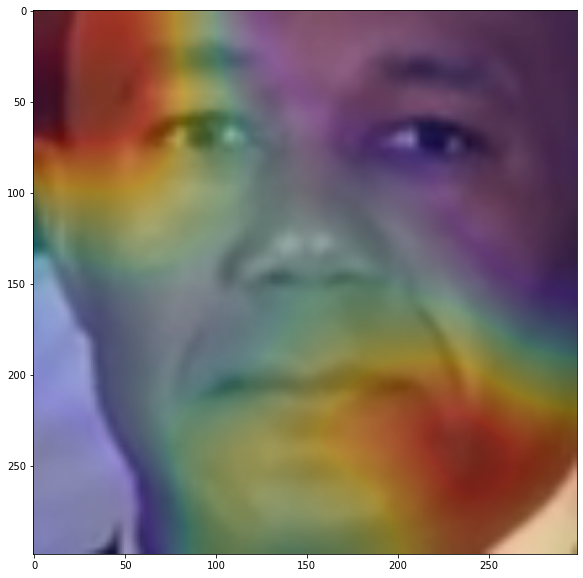

In [ ]:
focus_heatmap(acts,frames,2,4,5)
#do not change first and second params
#3rd parameter is which frame
#4th parameter is row
#5th parameter is column